# U-nets, vortex detection, and semantic segmentation

In this file, we will train a semantic image segmentation network to identify regions of high vorticity and velocity in our simulation, given only a screenshot of the fluid density. One appropriate choice of network architecture for this scenario is the U-net, named for its characteristic shape:

![](images/unet-arch.png)

Image courtesy of [[1]](https://arxiv.org/abs/1505.04597).

The intuition behind the U-net is that convolutional implementations coarse-grain data in the input image in order to extract low-level feature data. Coarse-graining is a non-invertible process and thus destroys information about correlations, so we feed the data at each layer forward, to build up an image which has the same size and resolution as the input and has access to the correlations learned at each CONV block.

In [1]:
import numpy as np
import tensorflow as tf
import graphviz as GraphViz
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, UpSampling2D, Cropping2D, Concatenate
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import pydot
from IPython.display import SVG
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [2]:
def ConvBlock(X, basename, filters=64, size=3, stride=1, padding=0):
    """
    Implementation of a single convolutional block in the UNet

    Arguments:
    X  -- the network state
    basename -- how TensorFlow will refer to this ConvBlock
    filter -- how many channels to produce in the layer
    size -- filter size (square)
    stride -- convolution stride amount

    Returns:
    X after the convolution is achieved
    """
    
    X = Conv2D(filters, (size, size), strides = (stride, stride), padding="same", name = basename+'a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+basename+'a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters, (size, size), strides = (stride, stride), padding="same", name = basename+'b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_'+basename+'b')(X)
    X = Activation('relu')(X)
    
    return X

In [3]:
def UpConv(X, X_shortcut, sampling=2):
    """
    Implementation of the up-conv step depicted above.

    Arguments:
    X -- the network state
    X_shortcut -- the shortcut state to combine with X after upsampling
    sampling -- the factor by which to upsample (recommended 2)

    Returns: 
    X after the upscaling is achieved and the short-circuit implemented
    """
    
    X = UpSampling2D(size=(sampling, sampling), interpolation='nearest')(X)
    
    # Shortcut will be larger than the shape, so prepare to crop
    crop_x = X_shortcut.shape.as_list()[1] - X.shape.as_list()[1]
    crop_y = X_shortcut.shape.as_list()[2] - X.shape.as_list()[2]

    # In case the shape difference is odd for some reason, keep track
    x_rem = crop_x % 2
    y_rem = crop_y % 2
    
    # Get the correct numbers to crop by
    crop_x = int(np.floor(float(crop_x)/2.0))
    crop_y = int(np.floor(float(crop_y)/2.0))
    
    # Crop the shortcut and add in filters to ensure that it has the same as X. 
    X_shortcut = Cropping2D(cropping = ((crop_x,crop_x + x_rem),(crop_y,crop_y + y_rem)))(X_shortcut)
    X_shortcut = Concatenate(axis=-1)([X_shortcut,X_shortcut])
    
    # Add the layers
    X = Add()([X_shortcut,X])
    return X

In [4]:
def UNet(input_shape = (525, 512, 3), filters_init=64):
    """
    Implementation of UNet architecture depicted above.

    Arguments:
    input_shape -- shape of the images of the dataset
    filters_init -- number of filters in the first ConvBlock

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    X = ConvBlock(X_input, 'convd1', filters=filters_init, size=3, stride=1) # Stage 1, downward moving
    X_shortcut_1 = X                                                         # Save shortcut
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)                              # Downward step 1 -> 2
    
    X = ConvBlock(X, 'convd2', filters=filters_init*2, size=3, stride=1)     # Stage 2, downward moving
    X_shortcut_2 = X                                                         # Save shortcut
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)                              # Downward step 2 -> 3
    
    X = ConvBlock(X, 'convd3', filters=filters_init*4, size=3, stride=1)     # Stage 3, downward moving
    X_shortcut_3 = X                                                         # Save shortcut
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)                              # Downward step 3 -> 4
    
    X = ConvBlock(X, 'convd4', filters=filters_init*8, size=3, stride=1)     # Stage 4, bottom
    X = UpConv(X, X_shortcut_3, sampling=2)                                  # Upward step 4 -> 3, adding short circuit
    
    X = ConvBlock(X, 'convu3', filters=filters_init*4, size=3, stride=1)     # Stage 3, upward moving
    X = UpConv(X, X_shortcut_2, sampling=2)                                  # Upward step 3 -> 2, adding short circuit
    
    X = ConvBlock(X, 'convu2', filters=filters_init*2, size=3, stride=1)     # Stage 2, upward moving
    X = UpConv(X, X_shortcut_1, sampling=2)                                  # Upward step 2 -> 1, adding short circuit
    
    X = ConvBlock(X, 'convu1', filters=filters_init, size=3, stride=1)       # Stage 1, top
    
    
    # Output layer
    
    # Layer will be smaller than the input shape due to odd number of pixels.
    # Insert padding, then apply last convolutional layer
    pad_x = X_input.shape.as_list()[1] - X.shape.as_list()[1]
    pad_y = X_input.shape.as_list()[2] - X.shape.as_list()[2]
    x_rem = pad_x % 2
    y_rem = pad_y % 2
    pad_x = int(np.floor(float(pad_x)/2.0))
    pad_y = int(np.floor(float(pad_y)/2.0))
    
    X = ZeroPadding2D(padding=((pad_x,pad_x + x_rem),(pad_y,pad_y+y_rem)))(X)
    X = Conv2D(1, (1, 1), strides = (1, 1), name = 'convOut', padding="same", kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_convOut')(X)
    X = Activation('sigmoid')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='UNet')

    return model

In [5]:
# Define the model
model = UNet(input_shape = (512, 525, 3), filters_init = 32)

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 525, 3  0           []                               
                                )]                                                                
                                                                                                  
 convd1a (Conv2D)               (None, 512, 525, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_convd1a (BatchNormalization  (None, 512, 525, 32  128        ['convd1a[0][0]']                
 )                              )                                                              

In [12]:
from utils import generate_data_from_datasets,delete_data_subdirs

delete_data_subdirs("data/")

train_datasets = {
    "d0p05_v0p05_p0_v1_sUsH_OLD" : "*"
}

dev_datasets = {
    "d0p05_v0p05_p0_v1_sUsH_OLD" : "*"
}

test_datasets = {
    "d0p05_v0p05_p0_v1_sUsH_OLD" : "*"
}

datasets = {
            "train": train_datasets, 
            "dev":   dev_datasets, 
            "test":  test_datasets
           }

generate_data_from_datasets("data/", "datasets/", datasets, curlThreshold = 0.02, velocityThreshold = 9.0) 

For segment train , processing * images from dataset d0p05_v0p05_p0_v1_sUsH_OLD
	 - Found 0 images in train image directory
	 - Pulling  13 images from datasets//d0p05_v0p05_p0_v1_sUsH_OLD/ out of max 13
 - Done with dataset 

For segment dev , processing * images from dataset d0p05_v0p05_p0_v1_sUsH_OLD
	 - Found 0 images in dev image directory
	 - Pulling  13 images from datasets//d0p05_v0p05_p0_v1_sUsH_OLD/ out of max 13
 - Done with dataset 

For segment test , processing * images from dataset d0p05_v0p05_p0_v1_sUsH_OLD
	 - Found 0 images in test image directory
	 - Pulling  13 images from datasets//d0p05_v0p05_p0_v1_sUsH_OLD/ out of max 13
 - Done with dataset 




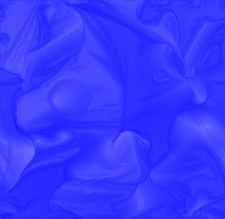
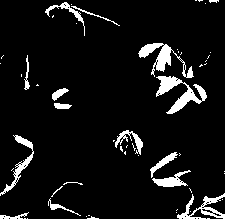
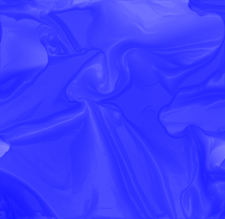
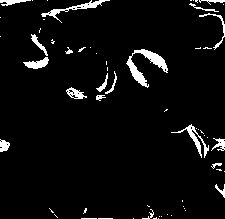
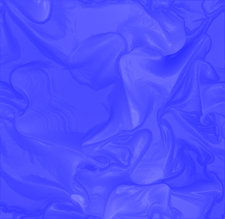
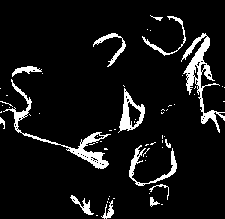
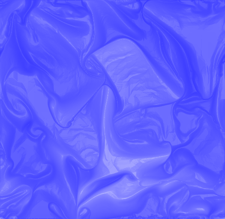
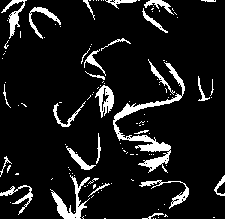


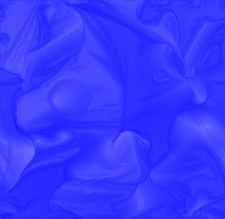
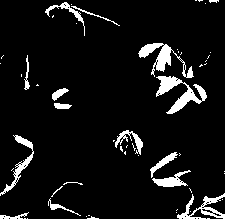
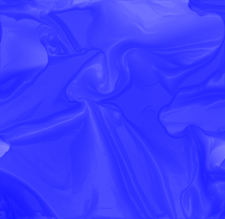
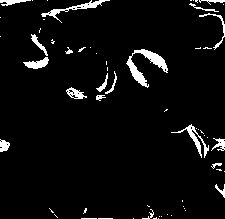
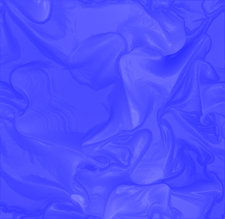
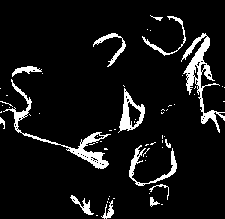
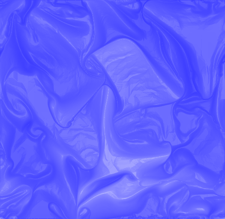
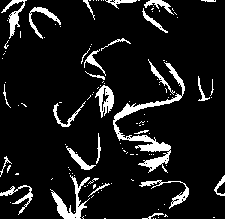

In [13]:
from PIL import Image
import numpy as np
import ipyplot

def flatten(t):
    return [item for sublist in t for item in sublist]

num_im = 4
ims = [["data/train/image/img/%i.png"%ii,"data/train/mask/img/%i.png"%ii] for ii in range(1,num_im+1)]
labels = [["image %i"%ii, "mask %i"%ii] for ii in range(1,num_im+1)]
ims = flatten(ims)
labels=flatten(labels)
ims = [Image.open(im) for im in ims]
    
ipyplot.plot_images(ims, labels, max_images=20, img_width=225)

In [22]:
# Create data generators
seed = 909 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
train_datagen_im = image.ImageDataGenerator()
train_datagen_ma = image.ImageDataGenerator()  # to make mask as feedable formate (256,256,1)
dev_datagen_im = image.ImageDataGenerator()
dev_datagen_ma = image.ImageDataGenerator()  # to make mask as feedable formate (256,256,1)
test_datagen_im = image.ImageDataGenerator()
test_datagen_ma = image.ImageDataGenerator()  # to make mask as feedable formate (256,256,1)

# Properties
Improps = {
    "seed": seed,
    "class_mode": None,
    "target_size": (512,525),
    "batch_size": 1
}

Maprops = {
    "seed": seed,
    "class_mode": None,
    "target_size": (512,525),
    "batch_size": 1
}


# Create filestreaming objects
train_gen_im = train_datagen_im.flow_from_directory("data/train/image", **Improps)
train_gen_ma = train_datagen_ma.flow_from_directory("data/train/mask", **Maprops)
dev_gen_im = train_datagen_im.flow_from_directory("data/dev/image/",  **Improps)
dev_gen_ma = train_datagen_ma.flow_from_directory("data/dev/mask/",   **Maprops)
test_gen_im = train_datagen_im.flow_from_directory("data/test/image/",  **Improps)
test_gen_ma = train_datagen_ma.flow_from_directory("data/test/mask/",   **Maprops)

# Zip masks and images together
train_generator = zip(train_gen_im, train_gen_ma)
dev_generator   = zip(dev_gen_im,   dev_gen_ma)
test_generator  = zip(test_gen_im,  test_gen_ma)

STEP_SIZE_TRAIN=train_gen_im.n//train_gen_im.batch_size
STEP_SIZE_VALID=dev_gen_im.n//dev_gen_im.batch_size
print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
13 13


In [17]:
model.fit_generator(generator=train_generator,
                    validation_data=dev_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1) # one forward/backward pass of training data
                    #use_multiprocessing=True,
                    #workers=3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


13/13 [==============================] - ETA: 0s - loss: -9.6483 - accuracy: 0.6411

W1118 20:42:28.122165 4682124800 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd1368801e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 56s 4s/step - loss: -9.6483 - accuracy: 0.6411 - val_loss: -18586.8945 - val_accuracy: 0.0087


In [20]:
preds = model.evaluate_generator(generator=dev_generator,steps=STEP_SIZE_VALID)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Loss = -20285.95703125
Test Accuracy = 0.008653273805975914


In [25]:
STEP_SIZE_TEST=test_gen_im.n//test_gen_im.batch_size

test_gen_im.reset()
test_gen_ma.reset()
pred=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """
W1118 20:46:41.767946 4682124800 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fd0d31b3510> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
13/13 [==============================] - 10s 752ms/step


In [48]:
test_masks = [((x > 0.5)*255.).astype(int) for x in pred]
test_masks = [Image.fromarray(x) for x in test_masks]

TypeError: Cannot handle this data type: (1, 1, 1), <i8